In [ ]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project (do not delete!)/bayesian_network/examples/1_darcy_flow"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [1]:
from dlroms import *
from dlroms.dnns import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output as clc
import sys
sys.path.append(os.path.join("..", "..", "dlroms"))
from bayesian import *

# Setup

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Domain and mesh definition

domain = fe.rectangle((0.0, 0.0), (1.0, 1.0))
mesh = fe.mesh(domain, stepsize=0.05)
V = fe.space(mesh, 'CG', 1) # 441 dofs
l2 = L2(V) # L2 norm

clc()

In [4]:
# Load train and test data

path_train = os.path.join(os.getcwd(), "snapshots", "snapshots_train_C.npz")
data_train = np.load(path_train)

N_train = data_train['K'].shape[0]
K_train = torch.tensor(data_train['K'].astype(np.float32)).to(device)
p_train = torch.tensor(data_train['p'].astype(np.float32)).to(device)
u_x_train = torch.tensor(data_train['u_x'].astype(np.float32)).to(device)
u_y_train = torch.tensor(data_train['u_y'].astype(np.float32)).to(device)

path_test = os.path.join(os.getcwd(), "snapshots", "snapshots_test_C.npz")
data_test = np.load(path_test)

N_test = data_test['K'].shape[0]
K_test = torch.tensor(data_test['K'].astype(np.float32)).to(device)
p_test = torch.tensor(data_test['p'].astype(np.float32)).to(device)
u_x_test = torch.tensor(data_test['u_x'].astype(np.float32)).to(device)
u_y_test = torch.tensor(data_test['u_y'].astype(np.float32)).to(device)

# Neural network cores

In [ ]:
m = 16

# Encoder
psi = Reshape(1, 21, 21) + \
      Conv2D(6, (1, m), stride=1, activation=torch.tanh) + \
      Conv2D(7, (m, 2 * m), stride=1, activation=torch.tanh) + \
      Conv2D(7, (2 * m, 4 * m), stride=1, activation=None)

# Decoder
psi_prime = Deconv2D(7, (4 * m, 2 * m), stride=1, activation=torch.tanh) + \
            Deconv2D(7, (2 * m, m), stride=1, activation=torch.tanh) + \
            Deconv2D(6, (m, 1), stride=1, activation=None) + \
            Reshape(-1)

print("Encoder trainable parameters:", psi.dof())
print("Decoder trainable parameters:", psi_prime.dof())

# Pressure Bayesian network

In [15]:
# Bayesian network for pressure

p_model = DFNN(psi, psi_prime)

p_bayes = Bayesian(p_model)

if torch.cuda.is_available():
	p_bayes.cuda()

p_trainer = SVGD(p_bayes, lr=1e-3, n_samples=30)
p_trainer.He()
p_bayes.set_trainer(p_trainer)

In [ ]:
p_bayes.train(K_train, p_train, ntrain=int(0.9*N_train), lr=1e-3, loss=mse(l2), epochs=1000)

In [10]:
# Compute mean and variance of predictions

p_pred_bayes_mean_train, p_pred_bayes_var_train = p_bayes.sample(K_train, n_samples=30)
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.sample(K_test, n_samples=30)

In [ ]:
# Compute relative error

error_train = mre(l2)(p_train, p_pred_bayes_mean_train)
error_test = mre(l2)(p_test, p_pred_bayes_mean)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

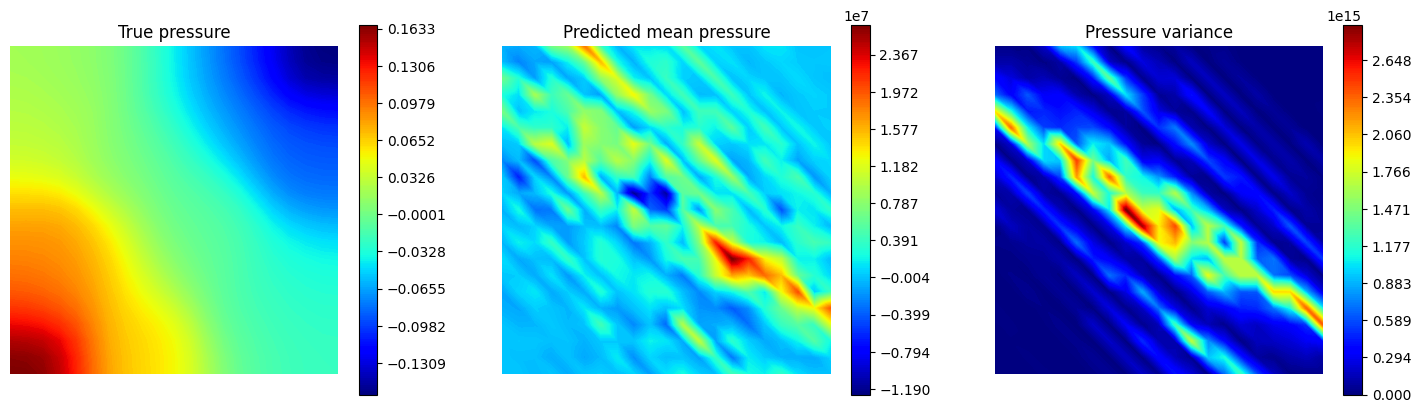

In [13]:
idx = 50

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(p_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [ ]:
# Save trainer state

checkpoint_dir = 'checkpoints'

if not os.path.exists(checkpoint_dir):
	os.makedirs(checkpoint_dir)

p_trainer.save_particles(os.path.join(checkpoint_dir, 'p_particles.pth'))

# Velocity Bayesian network (x-component)

In [ ]:
# Bayesian network for velocity (x-component)

u_x_model = DFNN(psi, psi_prime)

u_x_bayes = Bayesian(u_x_model)

if torch.cuda.is_available():
	u_x_bayes.cuda()

u_x_trainer = SVGD(u_x_bayes, lr=1e-3, n_samples=30)
u_x_trainer.He()
u_x_bayes.set_trainer(u_x_trainer)

In [ ]:
u_x_bayes.train(K_train, u_x_train, ntrain=int(0.9*N_train), lr=1e-3, loss=mse(l2), epochs=1000)

In [ ]:
# Compute mean and variance of predictions

u_x_pred_bayes_mean_train, u_x_pred_bayes_var_train = u_x_bayes.sample(K_train, n_samples=30)
u_x_pred_bayes_mean, u_x_pred_bayes_var = u_x_bayes.sample(K_test, n_samples=30)

In [ ]:
# Compute relative error

error_train = mre(l2)(u_x_train, u_x_pred_bayes_mean_train)
error_test = mre(l2)(u_x_test, u_x_pred_bayes_mean)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

In [ ]:
idx = 50

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(u_x_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [ ]:
# Save trainer state

u_x_trainer.save_particles(os.path.join(checkpoint_dir, 'u_x_particles.pth'))

# Velocity Bayesian network (y-component)

In [ ]:
# Bayesian network for velocity (y-component)

u_y_model = DFNN(psi, psi_prime)

u_y_bayes = Bayesian(u_y_model)

if torch.cuda.is_available():
	u_y_bayes.cuda()

u_y_trainer = SVGD(u_y_bayes, lr=1e-3, n_samples=30)
u_y_trainer.He()
u_y_bayes.set_trainer(u_y_trainer)

In [ ]:
u_y_bayes.train(K_train, u_y_train, ntrain=int(0.9*N_train), lr=1e-3, loss=mse(l2), epochs=1000)

In [ ]:
# Compute mean and variance of predictions

u_y_pred_bayes_mean_train, u_y_pred_bayes_var_train = u_y_bayes.sample(K_train, n_samples=30)
u_y_pred_bayes_mean, u_y_pred_bayes_var = u_y_bayes.sample(K_test, n_samples=30)

In [ ]:
# Compute relative error

error_train = mre(l2)(u_y_train, u_y_pred_bayes_mean_train)
error_test = mre(l2)(u_y_test, u_y_pred_bayes_mean)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

In [ ]:
idx = 50

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_y_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(u_y_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(u_y_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [ ]:
# Save trainer state

u_y_trainer.save_particles(os.path.join(checkpoint_dir, 'u_y_particles.pth'))

Reliability Diagram:

1. Compute the p% predictive interval for each test data point based on the Gaussian quantiles using the predictive mean and variance;
2. Compute the frequency of the test targets that fall within this predictive interval.

For a well-calibrated regression model, the observed frequency should be close to p%. The reliability diagram is the plot of the observed frequency with respect to p.

In [ ]:
from scipy.stats import norm

u_x_test_np = u_x_test.cpu().numpy().flatten()
u_x_pred_bayes_mean_np = u_x_pred_bayes_mean.cpu().numpy().flatten()
u_x_pred_bayes_var_np = u_x_pred_bayes_var.cpu().numpy().flatten()

quantiles = np.linspace(0, 1, 100)

calibration_curve = np.zeros_like(quantiles)

for i in range(len(u_x_test_np)):
	normal_quantiles = norm.ppf(quantiles, loc=u_x_pred_bayes_mean_np[i], scale=np.sqrt(u_x_pred_bayes_var_np[i]))
	mask = (normal_quantiles > u_x_test_np[i])
	calibration_curve += mask

calibration_curve /= len(u_x_test_np)

plt.plot(quantiles, calibration_curve)
plt.plot(quantiles, quantiles, '--')
plt.show()